In [2]:
import pandas as pd
import networkx as nx
from community import community_louvain
from datetime import datetime
import os

# Load your full dataset
csv_path = r"/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/Combined Dabs W Network/r_dabs_network.csv"
df = pd.read_csv(csv_path)

# Convert created_utc to datetime and extract year/quarter
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df['year'] = df['created_utc'].dt.year
df['quarter'] = df['created_utc'].dt.to_period('Q')

# Map id to author to trace parent relationships
id_to_author = dict(zip(df['id'], df['author']))

# Prepare final list of dataframes to merge later
quarterly_results = []

# Iterate through each quarter
for period, group in df.groupby('quarter'):
    print(f"Processing quarter: {period}")

    # Build reply graph for this quarter
    G = nx.DiGraph()
    for _, row in group.iterrows():
        author = row['author']
        parent_id = row['parent_id']
        if pd.notna(author) and pd.notna(parent_id):
            parent_author = id_to_author.get(parent_id.replace("t1_", "").replace("t3_", ""), None)
            if parent_author and parent_author != author:
                G.add_edge(author, parent_author)

    if len(G.nodes) < 10:
        print(f"Skipped {period} (too few users)")
        continue

    # PageRank
    pagerank = nx.pagerank(G)
    nx.set_node_attributes(G, pagerank, 'pagerank')

    # Louvain community detection
    partition = community_louvain.best_partition(G.to_undirected())
    nx.set_node_attributes(G, partition, 'community')

    # Average PageRank per community
    community_scores = {}
    for user, comm in partition.items():
        community_scores.setdefault(comm, []).append(pagerank.get(user, 0))
    avg_scores = {
        comm: sum(prs)/len(prs) for comm, prs in community_scores.items()
    }

    # Select most influential community
    top_comm_id = max(avg_scores.items(), key=lambda x: x[1])[0]
    top_users = [u for u, cid in partition.items() if cid == top_comm_id]

    # Pull posts/comments from that cluster this quarter
    quarter_df = group[group['author'].isin(top_users)].copy()
    quarter_df['quarter'] = str(period)  # Add quarter label
    quarterly_results.append(quarter_df)

# Combine all quarterly data
final_df = pd.concat(quarterly_results, ignore_index=True)

# Save to Desktop
output_path = os.path.expanduser("~/Desktop/influential_clusters_all_quarters.csv")
final_df.to_csv(output_path, index=False)
print(f"\n✅ Saved all top clusters with quarter labels to:\n{output_path}")


Processing quarter: 2012Q1
Skipped 2012Q1 (too few users)
Processing quarter: 2012Q2
Skipped 2012Q2 (too few users)
Processing quarter: 2012Q3
Skipped 2012Q3 (too few users)
Processing quarter: 2012Q4
Skipped 2012Q4 (too few users)
Processing quarter: 2013Q1
Skipped 2013Q1 (too few users)
Processing quarter: 2013Q2
Skipped 2013Q2 (too few users)
Processing quarter: 2013Q3
Skipped 2013Q3 (too few users)
Processing quarter: 2013Q4
Processing quarter: 2014Q1
Processing quarter: 2014Q2
Processing quarter: 2014Q3
Processing quarter: 2014Q4
Processing quarter: 2015Q1
Processing quarter: 2015Q2
Processing quarter: 2015Q3
Processing quarter: 2015Q4
Processing quarter: 2016Q1
Processing quarter: 2016Q2
Processing quarter: 2016Q3
Processing quarter: 2016Q4
Processing quarter: 2017Q1
Processing quarter: 2017Q2
Processing quarter: 2017Q3
Processing quarter: 2017Q4
Processing quarter: 2018Q1
Processing quarter: 2018Q2
Processing quarter: 2018Q3
Processing quarter: 2018Q4
Processing quarter: 2019Q1


In [3]:
df2 = pd.read_csv('/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/RQ3/influential_clusters_all_quarters.csv')
df2.head()

/var/folders/ty/kkyy7c9s4059czrtyxg_0mz40000gn/T/ipykernel_42523/2173600487.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/RQ3/influential_clusters_all_quarters.csv')


,node_type,depth,id,parent_id,post_id,created_utc,author,score,body_text,parent_body_text,distinguished,num_comments,media,year,quarter
0,post,0,1u2fuu,NaN,1u2fuu,2013-12-31 03:56:45,dabMasterYoda,10,Rig and tools\n\nnan,NaN,NaN,1.0,NaN,2013,2013Q4
1,comment,1,cee2qn7,1u2fuu,NaN,2013-12-31 14:19:48,dabMasterYoda,1,Agreed. I'll be posting any new pieces I get a...,Rig and tools\n\nnan,NaN,NaN,NaN,2013,2013Q4
2,post,0,1u3bcw,NaN,1u3bcw,2013-12-31 14:20:50,dabMasterYoda,7,Custom Nitro Torch\n\nnan,NaN,NaN,1.0,NaN,2013,2013Q4
3,post,0,1u3d3b,NaN,1u3d3b,2013-12-31 14:50:09,Jagyk,4,The (relatively) new rig.\n\nnan,NaN,NaN,4.0,NaN,2013,2013Q4
4,comment,1,cee7rlp,1u3d3b,NaN,2013-12-31 18:14:13,dabMasterYoda,2,How do you like domeless nail vs standard?,The (relatively) new rig.\n\nnan,NaN,NaN,NaN,2013,2013Q4


In [4]:
import pandas as pd
import networkx as nx
from community import community_louvain, modularity

# Load your full dataset
csv_path = r"/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/Combined Dabs W Network/r_dabs_network.csv"
df = pd.read_csv(csv_path)

# Convert time and prepare for grouping
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df['quarter'] = df['created_utc'].dt.to_period('Q')
id_to_author = dict(zip(df['id'], df['author']))

# Store modularity scores
modularity_scores = []

for period, group in df.groupby('quarter'):
    G = nx.DiGraph()
    for _, row in group.iterrows():
        author = row['author']
        parent_id = row['parent_id']
        if pd.notna(author) and pd.notna(parent_id):
            parent_author = id_to_author.get(parent_id.replace("t1_", "").replace("t3_", ""), None)
            if parent_author and parent_author != author:
                G.add_edge(author, parent_author)

    if len(G.nodes) < 10:
        continue

    undirected_G = G.to_undirected()
    partition = community_louvain.best_partition(undirected_G)
    mod_score = modularity(partition, undirected_G)

    modularity_scores.append((str(period), mod_score))

# Show results
mod_df = pd.DataFrame(modularity_scores, columns=["Quarter", "Modularity Score"])
print(mod_df)


   Quarter  Modularity Score
0   2013Q4          0.549887
1   2014Q1          0.719325
2   2014Q2          0.568437
3   2014Q3          0.753651
4   2014Q4          0.594633
5   2015Q1          0.655944
6   2015Q2          0.634736
7   2015Q3          0.592379
8   2015Q4          0.763413
9   2016Q1          0.670795
10  2016Q2          0.676140
11  2016Q3          0.686024
12  2016Q4          0.694998
13  2017Q1          0.611714
14  2017Q2          0.462602
15  2017Q3          0.447980
16  2017Q4          0.422141
17  2018Q1          0.383837
18  2018Q2          0.364835
19  2018Q3          0.358470
20  2018Q4          0.304492
21  2019Q1          0.302571
22  2019Q2          0.324949
23  2019Q3          0.326173
24  2019Q4          0.310567
25  2020Q1          0.307531
26  2020Q2          0.305809
27  2020Q3          0.331032
28  2020Q4          0.319439
29  2021Q1          0.334548
30  2021Q2          0.333976
31  2021Q3          0.303693
32  2021Q4          0.291112
33  2022Q1    

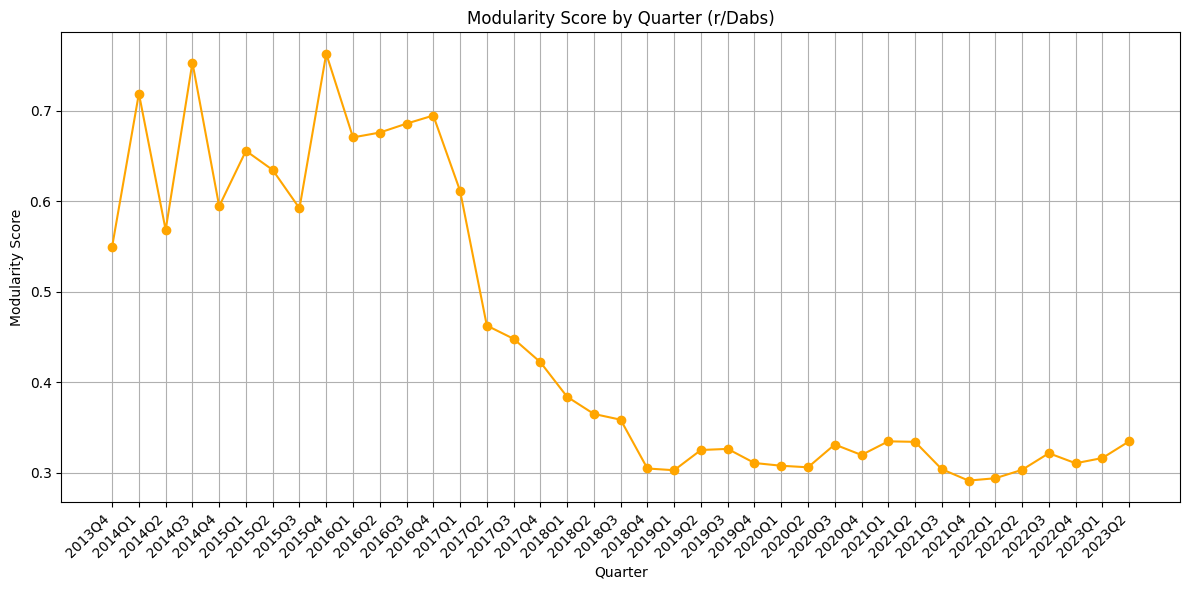

In [5]:
import matplotlib.pyplot as plt

# Ensure Quarter is string and filter to <= 2023Q2
mod_df['Quarter'] = mod_df['Quarter'].astype(str)
mod_df_filtered = mod_df[mod_df['Quarter'] <= '2023Q2']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(mod_df_filtered['Quarter'], mod_df_filtered['Modularity Score'], marker='o', linestyle='-', color='orange')
plt.xticks(rotation=45, ha='right')
plt.title("Modularity Score by Quarter (r/Dabs)")
plt.xlabel("Quarter")
plt.ylabel("Modularity Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:


# Calculate total score per user
top_users = df2.groupby('author')['score'].sum().sort_values(ascending=False).head(75).reset_index()

# Print results
print("Top 30 users by total score:\n")
print(top_users)


Top 30 users by total score:

               author  score
0             upstylo   4723
1    Blackberry-Scary   4344
2             snobord   4316
3             pure619   3220
4           entalt4me   2974
..                ...    ...
70        bockscar888   1042
71      phobichorizon   1032
72  noface_nocase-301   1025
73        Floodbucket   1008
74         colivera86   1001

[75 rows x 2 columns]


In [7]:
import pandas as pd
import networkx as nx

# Load network dataset
df = pd.read_csv("/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/Combined Dabs W Network/r_dabs_network.csv")
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df['quarter'] = df['created_utc'].dt.to_period('Q')
id_to_author = dict(zip(df['id'], df['author']))

# Epochs
epoch_ranges = {
    "E0_Seed": ["2012Q1", "2016Q4"],
    "E1_Takeoff": ["2017Q1", "2019Q4"],
    "E2_PandemicBoom": ["2020Q1", "2021Q4"],
    "E3_PostPeak": ["2022Q1", "2023Q4"]
}

top_users = []

for label, (start_q, end_q) in epoch_ranges.items():
    slice_df = df[(df["quarter"] >= start_q) & (df["quarter"] <= end_q)]

    G = nx.DiGraph()
    for _, row in slice_df.iterrows():
        author = row['author']
        parent_id = row['parent_id']
        if pd.notna(author) and pd.notna(parent_id):
            parent_author = id_to_author.get(parent_id.replace("t1_", "").replace("t3_", ""), None)

            # Skip deleted/removed accounts
            if author in ["[deleted]", "[removed]"] or parent_author in ["[deleted]", "[removed]"]:
                continue

            if parent_author and parent_author != author:
                G.add_edge(author, parent_author)

    if len(G) == 0:
        continue

    pr = nx.pagerank(G)
    top_25 = sorted(pr.items(), key=lambda x: x[1], reverse=True)

    # Filter out deleted/removed before writing
    clean_top_25 = [
        {"Epoch": label, "Author": user}
        for user, _ in top_25
        if user not in ["[deleted]", "[removed]"]
    ][:25]

    top_users.extend(clean_top_25)

# Save to CSV
top_users_df = pd.DataFrame(top_users)
output_path = "/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/top_influential_users.csv"
top_users_df.to_csv(output_path, index=False)
print(f"✅ Saved top influential users CSV to: {output_path}")


✅ Saved top influential users CSV to: /Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/top_influential_users.csv


In [8]:
import pandas as pd
import networkx as nx
from community import community_louvain, modularity
from collections import Counter

# Load network data
df = pd.read_csv("/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/Combined Dabs W Network/r_dabs_network.csv")
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df['quarter'] = df['created_utc'].dt.to_period('Q')
id_to_author = dict(zip(df['id'], df['author']))

# Load top users
top_users_df = pd.read_csv("/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/top_influential_users.csv")
top_users_by_epoch = top_users_df.groupby("Epoch")["Author"].apply(set).to_dict()

# Define epochs
epoch_ranges = {
    "E0_Seed": ["2012Q1", "2016Q4"],
    "E1_Takeoff": ["2017Q1", "2019Q4"],
    "E2_PandemicBoom": ["2020Q1", "2021Q4"],
    "E3_PostPeak": ["2022Q1", "2023Q4"]
}

# Store results
modularity_scores = []
edge_rows = []
full_rows = []

for label, (start_q, end_q) in epoch_ranges.items():
    if label not in top_users_by_epoch:
        print(f"⚠️ Skipping {label}: no top users provided")
        continue

    top_users = top_users_by_epoch[label]
    slice_df = df[(df["quarter"] >= start_q) & (df["quarter"] <= end_q)]

    G = nx.DiGraph()
    for _, row in slice_df.iterrows():
        author = row['author']
        parent_id = row['parent_id']
        if pd.notna(author) and pd.notna(parent_id):
            parent_author = id_to_author.get(parent_id.replace("t1_", "").replace("t3_", ""), None)
            if (
                parent_author and parent_author != author
                and author in top_users
                and parent_author in top_users
            ):
                G.add_edge(author, parent_author)

    if len(G.nodes) < 10:
        print(f"⚠️ Skipping {label}: too few top-user interactions")
        continue

    undirected_G = G.to_undirected()
    partition = community_louvain.best_partition(undirected_G)
    mod_score = modularity(partition, undirected_G)
    sizes = Counter(partition.values())

    modularity_scores.append({
        "Epoch": label,
        "Nodes": len(G),
        "Edges": G.number_of_edges(),
        "Communities": len(sizes),
        "Avg Community Size": round(sum(sizes.values()) / len(sizes), 2),
        "Modularity Score": round(mod_score, 4),
        "Largest Community": max(sizes.values())
    })

    # Collect edge list and usernames involved
    edge_users = set()
    for u, v in G.edges():
        edge_rows.append({"Epoch": label, "Source": u, "Target": v})
        edge_users.update([u, v])

    # Pull all original rows authored by top-user participants
    matching_rows = slice_df[slice_df["author"].isin(edge_users)].copy()
    matching_rows["Epoch"] = label
    full_rows.append(matching_rows)

# Output modularity scores
mod_df = pd.DataFrame(modularity_scores)
print(mod_df)

# Export edges
edges_df = pd.DataFrame(edge_rows)
edges_df.to_csv("/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/top_influential_threads.csv", index=False)

# Export full user rows
full_df = pd.concat(full_rows, ignore_index=True)
full_df.to_csv("/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/top_influential_full_data.csv", index=False)

print("✅ Exported full influential user rows and thread connections.")


             Epoch  Nodes  Edges  Communities  Avg Community Size  \
0          E0_Seed     24     49            6                4.00   
1       E1_Takeoff     25    370            3                8.33   
2  E2_PandemicBoom     25    275            3                8.33   
3      E3_PostPeak     25    327            2               12.50   

   Modularity Score  Largest Community  
0            0.4561                  7  
1            0.0715                 12  
2            0.1692                 10  
3            0.0589                 13  
✅ Exported full influential user rows and thread connections.
